# Spectral Cube Modeling

## Imports 

* _time_ for timing 
* _multiprocessing.Pool_ for parallel processing on cube spaxels
* _pickle_ for pickling and unpickling IO to multiprocessing pools
* _numpy_ for array processing and math
* _matplotlib.pyplot_ for plotting images and spectra
* _astropy.io_ for reading and writing FITS cubes and images
* _astropy.visualization_ to construct RGB images
* _lmfit_ Levenberg-Marquart fitting package for model-fitting


In [1]:
import time
import multiprocessing as mp
from multiprocessing import Pool
import pickle

import numpy as np
from numpy import exp, loadtxt, pi, sqrt, arange, interp

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

from astropy.io import fits 
from astropy.visualization import make_lupton_rgb
from astropy import wcs
from astropy.wcs import WCS
import astropy.units as u
from astropy.utils import data
from astropy.modeling import models

import lmfit
from lmfit import Model, Minimizer, Parameters
from lmfit.model import save_modelresult


## Introduction
Analysis of JWST spectral cubes requires extracting spatial-spectral features of interest and measuring their
attributes. Here, we demonstrate 1-D spectral modeling applied to an individual spaxel, 900 spaxels in a cube, and spectra summed over spatial regions. Analysis of large JWST spectral data cubes can be computationally expensive, depending on number of spaxels modeled and number of free model parameters. This task can be made manageable by focusing on spatial sub-regions of interest or by minimizing model complexity.  Sub-regions in the cube are selected by location and line ratios. The spaxels in these regions are then summed and modeled with a combination of continuum, emission line, polycyclic aromatic hydrocarbon (PAH), and silicate dust features. Best-fitting model spectra are fit using the lmfit package, utilizing a Levenberg-Marquardt least-squares method. 



## Definitions of functions

### Scrolling
Limit scrolling in cell output.

In [2]:
%%javascript
IPython.OutputArea.auto_scroll_threshold=70;

<IPython.core.display.Javascript object>

### Extract, fit and plot single 1D spectrum

In [3]:
def extract_spec(a, b):
    """extract spec and errors from a,b coordinates"""
    spec_pix=data_cube[:,a,b]
    err_pix=error_cube[:,a,b]
    return spec_pix, err_pix

def fit_and_plot(spec, specerr, model, generic_pars, silicates=True):
    
    #Fitting
    start_time = time.time()
    result = model.fit(spec, generic_pars, weights=1./specerr, x=x)
    print('Time count')
    print("--- %s seconds ---" % (time.time() - start_time))
    print('Chi square red=',result.redchi)

    #Model Results
    fit_model = result.best_fit 
    fit_residual = spec - fit_model

    #Evaluate model components
    comps = result.eval_components()
    plaw_model=comps['pwl_']
    h2_model=x-x
    h2comp=['h55_','h61_','h69_','h80_','h96_','h122_']
    for comp in h2comp:
        h2_model+=comps[comp]
    ion_model=x-x
    atomiclines=['ArII','SIV','NeII']
    for comp in atomiclines:
        ion_model+=comps[comp+'_']
    pahs_model=fit_model-plaw_model-h2_model-ion_model
    if silicates: 
        sidust_model=comps['sidust1_']
        pahs_model=pahs_model-sidust_model
        
    #Plot results
    fig1=plt.figure(figsize=(15, 6), dpi= 150)
    frame1=fig1.add_axes((.1,.3,.8,.6))
    plt.errorbar(x, spec, yerr=specerr,label='Data', color='k')
    plt.plot(x, fit_model,label='Model',c='red')
    if silicates: plt.plot(x,sidust_model,label='Si Dust', c='orange')
    plt.plot(x, pahs_model,label='PAHs',c='magenta')
    plt.plot(x, h2_model,label='H2',c='g')
    plt.plot(x, ion_model,label='Ions',c='b')
    plt.ylabel(r"$Flux\ (Jy)$")
    plt.grid(linestyle=':')
    plt.legend()
    frame1.set_xticklabels([])

    frame2=fig1.add_axes((.1,.1,.8,.2))
    plt.errorbar(x,fit_residual,yerr=specerr)
    plt.plot(x, 0.*x, '-')
    plt.xlabel(r"$Wavelength\ (\mu m)$")
    plt.grid(linestyle=':')
    plt.show()     
    return result

def model_comps(result):
    #Evaluate model components
    comps = result.eval_components()
    plcomp=[]
    h2comp=[]
    pahcomp=[]
    sidustcomp=[]
    #print(comps.keys())
    for key in comps.keys(): 
        if key[0:3]=='pwl': plcomp.append(key)
        if key[0]=='h': h2comp.append(key)
        if key[0:3]=='PAH': pahcomp.append(key)
        if key[0:3]=='sid': sidustcomp.append(key)
       
    plaw_model=x-x
    h2_model=x-x
    ion_model=x-x
    pah_model=x-x
    sidust_model=x-x
    for comp in plcomp: plaw_model+=comps[comp]
    for comp in h2comp: h2_model+=comps[comp]
    for comp in pahcomp: pah_model+=comps[comp]
    for comp in sidustcomp: sidust_model+=comps[comp]
    atomiclines=['ArII','SIV','NeII']
    for comp in atomiclines:
        ion_model+=comps[comp+'_']
        
    return(plaw_model,h2_model,ion_model,pah_model,sidust_model)

def map2file(cube, map_array, filename):
    """Save a map array to FITS"""
    aux=cube
    aux[0].data = map_array
    name=str(name)
    aux.writeto(name)

### Model Functions
A variety of emission line, continuum and extinction models for spectral fitting.

In [4]:
def gaussian_old(x, amplitude, xcen,std):
    """1-d gaussian"""
    return amplitude * exp(-(x-xcen)**2 / (2*std**2))                           #Amplitude unit

def gaussian(x, amplitude, xcen, std):
    """1-d gaussian"""
    g1d=models.Gaussian1D(amplitude,xcen,std)
    return g1d(x)    

def linear(x, slope, intercept):
    """a linear function"""
    return slope*x + intercept

def powerlaw(x, c1, c2):
    """power law function"""
    return c1*(x**c2)

def drude(x, peakx, frac_FWHM, amplitude):
    """dust emission"""
    return ((amplitude*(frac_FWHM**2))/((x/peakx-peakx/x)**2+frac_FWHM**2))    #Amplitude unit

def pahdust(x, Oneplusz, amplitude_76, amplitude_113):
    """PAH dust emission"""
    
    #Ionized PAH features
    ionPAH_peakx=     [ 5.27, 5.70, 6.22, 6.69, 7.42, 7.60, 7.85, 8.33, 8.61]
    ionPAH_frac_FWHM= [0.034,0.035, 0.030,0.07, 0.126,0.044,0.053,0.050, 0.039]
    ionPAH_amplitude= [0.0,  0.0,   0.8,  0.0,  0.0,  1.0,  0.6,  0.0,   0.5]
    
    pahflux=x-x
    for peakx, frac_FWHM, ampl in zip(ionPAH_peakx,ionPAH_frac_FWHM,ionPAH_amplitude):
        peakx=peakx*Oneplusz
        ampl=amplitude_76*(ampl/ionPAH_amplitude[5])
        pahflux=pahflux+((ampl*(frac_FWHM**2))/((x/peakx-peakx/x)**2+frac_FWHM**2))

    #Neutral PAH features
    neutralPAH_peakx=     [10.68, 11.23,11.33]
    neutralPAH_peakx+=    [11.99,12.62,12.69,13.48,14.04,14.19,15.90, 16.45,17.04,17.375,17.87,18.92]
    neutralPAH_frac_FWHM= [0.020, 0.012,0.022]
    neutralPAH_frac_FWHM+=[0.045,0.042, 0.013,0.040,0.016,0.025,0.020,0.014,0.065, 0.012, 0.016,0.019]   
    neutralPAH_amplitude= [0.0,  0.6, 1.0]
    neutralPAH_amplitude+=[0.2,  0.3,   0.1,  0.0,  0.1,  0.1,  0.0,   0.0,  0.0,  0.0,   0.0,  0.0]
    
    for peakx, frac_FWHM, ampl in zip(neutralPAH_peakx,neutralPAH_frac_FWHM,neutralPAH_amplitude):
        peakx=peakx*Oneplusz
        ampl=amplitude_113*(ampl/neutralPAH_amplitude[2])
        pahflux=pahflux+((ampl*(frac_FWHM**2))/((x/peakx-peakx/x)**2+frac_FWHM**2))

    return pahflux    #Amplitude unit

def sidust(x, T, amplitude):
    """Silicate dust emission"""
    
    #pahfit_tau_agn -- Custom extinction curve built from weighted sum of two components: 
    #                  silicate profile (Drude functions), and an exponent 1.7 power-law.

    d1=drude(x,10.0,0.25,0.80)
    d2=drude(x,11.1,0.25,0.25)
    #d3=drude(x,17.0,0.40,0.40)
    ext=d1+d2  #+d3

    # Form linear combination of modified silicate and powerlaw.
    beta=0.1
    ext=(1. - beta)*ext + beta*(9.7/x)**1.7
    scale=1.0E-6
    si_em=amplitude*1.0E-6*3.97289E13/x**3/(exp(1.4387752E4/x/T)-1.)*ext
    
    return si_em

def blackbody(x, OnePlusZ, T, K):
    """black body function"""
    h=6.626196*10**(-27) #erg*s
    c=2.997924562*10**(10) #cm/s
    k=1.38*10**(-16) #erg/K
    Constant = 1.71828182846 / OnePlusZ
    EnergyRatio = ((1./(k*T))*OnePlusZ*h*c*10000)/x
    return Constant*K*(EnergyRatio**4)/(exp(EnergyRatio)-1.)                   #Jansky unit

def extinctiongal(x, tau):
    """Galactic center extinction"""
    ext=np.interp(x, wave, agal)      #Interpolate the data in x array
    return exp(-tau*ext)

def extinctionloc(x, tau):
    """Local ISM extinction"""
    ext=np.interp(x, wave, alocal)    #Interpolate the data in x array
    return exp(-tau*ext)

#Read extinction data from Chiar & Tielens (2005)
Boxdata="https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/cube_fitting/"
wave, agal, alocal = np.loadtxt(Boxdata+'chiar+tielens_2005.dat', skiprows=14, usecols=(0, 1, 2), unpack=True)

def gaussian_flux(x, ratio, xcen, std):
    """Same model of gaussian but with ratio"""
    amp=gauss_flux2amp(ratio,std,xcen)
    return gaussian(x, amp, xcen, std)

def drude_flux(x, peakx, frac_FWHM, ratio):
    """Same model of drude but with ratio"""
    amp=drude_flux2amp(ratio,frac_FWHM,peakx)
    return drude(x, peakx, frac_FWHM, amp)

def Modelcero(x):
    """Simple model of 0 to initialize some models"""
    return 0*x

def Modelconst(x, A):
    """Simple model of a constant"""
    return (0*x)+A

## Model Parameters 
Declare the parameters of model functions. Parameters are frozen by setting vary='False'
in the lmfit setpar command.  For now we are just fitting amplitudes of emission features.
Fits with more variable parameters take longer.

In [5]:
def setpar(pars,name,value,vary,minus):
    """Set any parameter"""
    pars[name].set(value,vary=vary,min=minus)
    
def extracpar(result,name):
    value=result.params[name].value
    return value

def gaussian_defpar_old(name,amplitude,xcen,fwhm,pars):
    """set the parameters for a gaussian"""
    std=fwhm2std(fwhm)
    name=str(name)
    xcen=xcen*OneZ
    setpar(pars,name+'_std',std,False,None)
    #setpar(pars,name+'_std',std,True,0)
    setpar(pars,name+'_xcen',xcen,False,None)
    setpar(pars,name+'_amplitude',amplitude,True,0)
    return #pars[name+'_std'].set(std,vary=False),pars[name+'_xcen'].set(xcen,vary=False),pars[name+'_amplitude'].set(amplitude)

def gaussian_defpar(name,amplitude,mean,stddev,pars):
    """set the parameters for a gaussian"""
    std=stddev
    name=str(name)
    xcen=mean*OneZ
    setpar(pars,name+'_std',std,False,None)
    #setpar(pars,name+'_std',std,True,0)
    setpar(pars,name+'_xcen',xcen,False,None)
    setpar(pars,name+'_amplitude',amplitude,True,0)
    return #pars[name+'_std'].set(std,vary=False),pars[name+'_xcen'].set(xcen,vary=False),pars[name+'_amplitude'].set(amplitude)


def drude_defpar(name, peakx, frac_FWHM, amplitude, pars):
    """set the parameters for a drude"""
    peakx=peakx*OneZ
    setpar(pars,name+'_frac_FWHM',frac_FWHM,False,None)
    #setpar(pars,name+'_frac_FWHM',frac_FWHM,True,0)
    setpar(pars,name+'_peakx',peakx,False,None)
    setpar(pars,name+'_amplitude',amplitude,True,0)    
    return #pars[name+'_frac_FWHM'].set(frac_FWHM,vary=False),pars[name+'_peakx'].set(peakx,vary=False),pars[name+'_amplitude'].set(amplitude)

def pahdust_defpar(name, Oneplusz, amplitude_76, amplitude_113, pars):
    """set the parameters for pdr dust"""
    setpar(pars,name+'_amplitude_76',amplitude_76,True,0) 
    setpar(pars,name+'_amplitude_113',amplitude_113,True,0) 
    setpar(pars,name+'_Oneplusz',Oneplusz,False,None)
    return #pars[name+'_frac_FWHM'].set(frac_FWHM,vary=False),pars[name+'_peakx'].set(peakx,vary=False),pars[name+'_amplitude'].set(amplitude)

def sidust_defpar(name,T,amplitude,pars):
    setpar(pars,name+'_amplitude',amplitude,True,0)
    setpar(pars,name+'_T',T,False,0)
    return

def gaussian_extractpars(prefix,result):
    """extract the parameters for a gaussian"""
    amp = result.params[prefix+'amplitude'].value
    cen = result.params[prefix+'xcen'].value
    std = result.params[prefix+'std'].value
    return amp, cen, std

def drude_extractpars(prefix,result):
    """extract the parameters for a drude"""
    ampl = result.params[prefix+'amplitude'].value
    peak = result.params[prefix+'peakx'].value         
    frac = result.params[prefix+'frac_FWHM'].value
    return ampl, peak, frac

def pahdust_extractpars(prefix,result):
    """extract the parameters for pahdust model"""
    ampl_76 = result.params[prefix+'amplitude_76'].value
    ampl_113 = result.params[prefix+'amplitude_113'].value
    return ampl_76, ampl_113  

def sidust_extractpars(prefix,result):
    """extract the parameters for pahdust model"""
    T = result.params[prefix+'T'].value
    ampl = result.params[prefix+'amplitude'].value
    
    return T,ampl 

def wave2cubecoor(wave,xwanted):
    """from wavelenght to coordinate in the cube"""
    count=0
    for line in wave:
        line=float(line)
        if abs(line-xwanted)<=0.001:
            coowanted=count
        else:
            count=count+1
    return coowanted

def map2file(cube,map_array,filename):
    """Save a map array to FITS"""
    aux=cube
    aux[0].data = map_array
    name=str(filename)
    aux.writeto(name)

### Calculate Line Flux and Line Width
Helper functions to calculate the fluxes and widths of emission features from model parameters.

In [6]:
def fwhm2std(fwhm):
    """from fwhm to standard deviation of a gaussian"""
    return fwhm/2.355

def gaussianline_flux(amp,std,cen):
    """calculate the integrate flux for a gaussian line"""
    #Units= amp:Jy cen:microns
    c= 29979.2458*10**10 #c in microns/s
    gaussianfactor=sqrt(2*pi)
    return amp*gaussianfactor*c*std/(cen**2)*10**(-23)      #erg s^{-1} cm^{-2}

def drudeline_flux(amp,frac,peak):
    """calculate the integrate flux for a drude line"""
    #Units= amp:Jy peak:microns
    c= 29979.2458*10**10 #c in microns/s
    drudefactor=pi
    return (amp*frac*drudefactor*c/((2*peak)))*10**(-23)   #erg s^{-1} cm^{-2}

def drude_flux2amp(flux,frac,peak):
    """calculate the amplitude from a flux for a drude line"""
    c= 29979.2458*10**10 #c in microns/s
    drudefactor=pi
    amp=(flux*2*peak)/(frac*drudefactor*c*10**(-23))
    return amp

def gauss_flux2amp(flux,std,peak):
    """calculate the amplitude from a flux for a gauss line"""
    c= 29979.2458*10**10 #c in microns/s
    gaussianfactor=sqrt(2*pi)
    amp=(flux*peak**2)/(gaussianfactor*c*std*10**(-23))
    return amp

## Input data
With the present lack of JWST flight data, we utilize the SL1 and SL2 spectral cubes generated
using CUBISM, from Spitzer IRS spectral mapping observations of the center of nearby
galaxy Messier 58. This galaxy has a radio-loud Seyfert nucleus that is exciting strong
H2 emission via shocks.  There is also significant star-formation, revealed by PAH emission
features.

Filename: /Users/pogle/.astropy/cache/download/py3/f368d01fbce7cd93d7e3fcf2501c2722
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     286   (35, 30, 117)   float32   
  1  WCS-TAB       1 BinTableHDU     13   1R x 1C   [117E]   
Filename: /Users/pogle/.astropy/cache/download/py3/0133638b1bdc9063bb9af07353223e2d
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     286   (35, 30, 77)   float32   
  1  WCS-TAB       1 BinTableHDU     13   1R x 1C   [77E]   
Trimmed cube dimensions: 194 30 32


/Users/pogle/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/colors.py:927: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


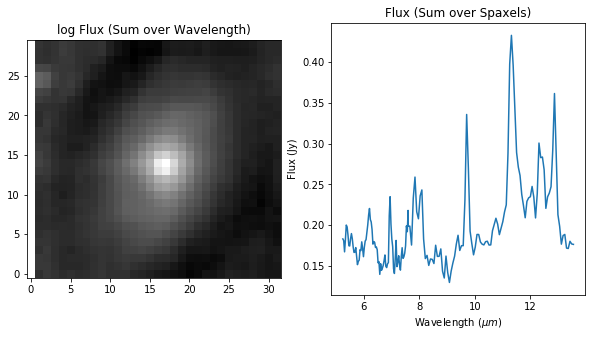

In [7]:
#Target 
targname='M58'

#Redshift
z=0.005060
OneZ=1.+z

#Download and open the data cubes and their uncertainties
BoxPath="https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/cube_fitting/"

cubeSL1 = fits.open(BoxPath+targname+'_SL1_cube.fits') 
errorsSL1 = fits.open(BoxPath+targname+'_SL1_cube_unc.fits')
cubeSL2 = fits.open(BoxPath+targname+'_SL2_cube.fits') 
errorsSL2 = fits.open(BoxPath+targname+'_SL2_cube_unc.fits')

#Cube Info
cubeSL1.info()
cubeSL2.info()

#Headers
hdr1 = cubeSL1[0].header                        
er_hdr1=errorsSL1[0].header
hdr2 = cubeSL2[0].header                               
er_hdr2=errorsSL2[0].header
#print(repr(hdr1))

#Data
data_cube1=[]
error_cube1=[]
wave1=[]
data_cube2=[]
error_cube2=[]
wave2=[]
data_cube1 = cubeSL1[0].data
error_cube1 = errorsSL1[0].data
data_cube2 = cubeSL2[0].data
error_cube2 = errorsSL2[0].data

#Wavelength
xwave1 = cubeSL1[1].data
xwave1 = xwave1.field(0)[0]
xwave2 = cubeSL2[1].data
xwave2 = xwave2.field(0)[0]
x=[]
for line in xwave2:
    x.append(float(line))
for line in xwave1:
    x.append(float(line))
x=np.array(x)

#Change the units from MJy/sr to Jy/pix
correct_unit1=abs(hdr1['CDELT1'])*abs(hdr1['CDELT2'])*0.0003046118*(10**6)    
data_cube1=data_cube1*correct_unit1
error_cube1=error_cube1*correct_unit1
correct_unit2=abs(hdr2['CDELT1'])*abs(hdr2['CDELT2'])*0.0003046118*(10**6)    
data_cube2=data_cube2*correct_unit2
error_cube2=error_cube2*correct_unit2

#Concatenate SL1 and SL2
data_cube=np.concatenate((data_cube2,data_cube1),axis=0)
error_cube=np.concatenate((error_cube2,error_cube1),axis=0)

#Reorder x and data_cube
xcor = x.argsort()
data_cube = data_cube[xcor]
error_cube = error_cube[xcor]
x=np.sort(x)

#Cube dimensions and trimming 
xsize, ysize, zsize = data_cube.shape
ytrim=0; ysize=ysize-ytrim
ztrim=3; zsize=zsize-ztrim
print('Trimmed cube dimensions:', xsize, ysize, zsize)

#Test output
#map2file(cubeSL2,data_cube,'test2.fits')

#Collapsed 2D image
cube_2dflux=np.sum(data_cube,axis=0)[0:ysize,0:zsize]

#Collapsed 1D spectrum
cube_1dflux=np.zeros(xsize,)
for a in arange(0,ysize):
    for b in arange(0,zsize):
        spec_pix,err_pix=extract_spec(a,b)
        cube_1dflux=cube_1dflux+spec_pix

f,(ax1,ax2)=plt.subplots(1,2, figsize=(10,5))
ax1.set_title('log Flux (Sum over Wavelength)')
ax1.imshow(cube_2dflux, origin='lower', cmap='gray', norm=LogNorm())
ax2.set_title('Flux (Sum over Spaxels)')
ax2.plot(x,cube_1dflux)
ax2.set_xlabel(r"Wavelength $(\mu m)$")
ax2.set_ylabel('Flux (Jy)')
plt.show()

## Model Parameter Starting Values
Set starting parameters for spectral model components. Use a PAH dust model with only two free parameters (7.6 and 11.3 micron PAH flux).  The rest of the PAH ratios are fixed by this 'pahdust' model, so that fitting the whole cube does not take so long.   Later, we will fit summed region spectra with all PAH amplitudes free.

In [8]:
#Power Law
p_law = Model(powerlaw,prefix='pwl_')
generic_pars = p_law.make_params()      
setpar(generic_pars,'pwl_c1',0.0002,True,None)
setpar(generic_pars,'pwl_c2',0.0015,True,None)

#PAH dust model with fixed PAH feature ratios
prefix='pahdust1_'
pahs = Model(pahdust,prefix=prefix)
generic_pars.update(pahs.make_params())
#print(generic_pars)
pahdust_defpar('pahdust1',1.00506,0.003,0.005,generic_pars)

#Silicate dust emission
prefix='sidust1_'
silicate= Model(sidust,prefix=prefix)
generic_pars.update(silicate.make_params())
sidust_defpar('sidust1', 190.,1.E-4,generic_pars)

#Gaussians with FWHM and X central from Smith et al 2007
#H2 molecular
h2lines=['55','61','69','80','96','122']
gaussH2=Model(Modelcero)
for line in h2lines:
    prefix='h'+line+'_'
    gaussH2+=Model(gaussian,prefix=prefix)
generic_pars.update(gaussH2.make_params())
gaussian_defpar('h55',0.05, 5.511, 0.053,generic_pars)
gaussian_defpar('h61',0.05, 6.109, 0.053,generic_pars)
gaussian_defpar('h69',0.05, 6.909, 0.053,generic_pars)
gaussian_defpar('h80',0.05, 8.026, 0.100,generic_pars)
gaussian_defpar('h96',0.05, 9.665, 0.100,generic_pars)
gaussian_defpar('h122',0.05, 12.278, 0.100,generic_pars)

#Atomic lines
atomiclines=['ArII','SIV','NeII']
gaussAt=Model(Modelcero)
for line in atomiclines:
    prefix = line+'_'
    gaussAt+=Model(gaussian,prefix=prefix)
generic_pars.update(gaussAt.make_params())
gaussian_defpar('ArII',0.05, 6.985, 0.053,generic_pars)
gaussian_defpar('SIV',0.05, 10.511, 0.100,generic_pars)
gaussian_defpar('NeII',0.05, 12.813, 0.100,generic_pars)

## Fit a Representative Spaxel
Fit a single spaxel in the cube and use the fit parameters to adjust the generic model starting parameters.

['pwl_c1', 'pwl_c2', 'sidust1_T', 'sidust1_amplitude', 'pahdust1_Oneplusz', 'pahdust1_amplitude_76', 'pahdust1_amplitude_113', 'h55_amplitude', 'h55_xcen', 'h55_std', 'h61_amplitude', 'h61_xcen', 'h61_std', 'h69_amplitude', 'h69_xcen', 'h69_std', 'h80_amplitude', 'h80_xcen', 'h80_std', 'h96_amplitude', 'h96_xcen', 'h96_std', 'h122_amplitude', 'h122_xcen', 'h122_std', 'ArII_amplitude', 'ArII_xcen', 'ArII_std', 'SIV_amplitude', 'SIV_xcen', 'SIV_std', 'NeII_amplitude', 'NeII_xcen', 'NeII_std']
Time count
--- 0.5891890525817871 seconds ---
Chi square red= 3.146585469405364


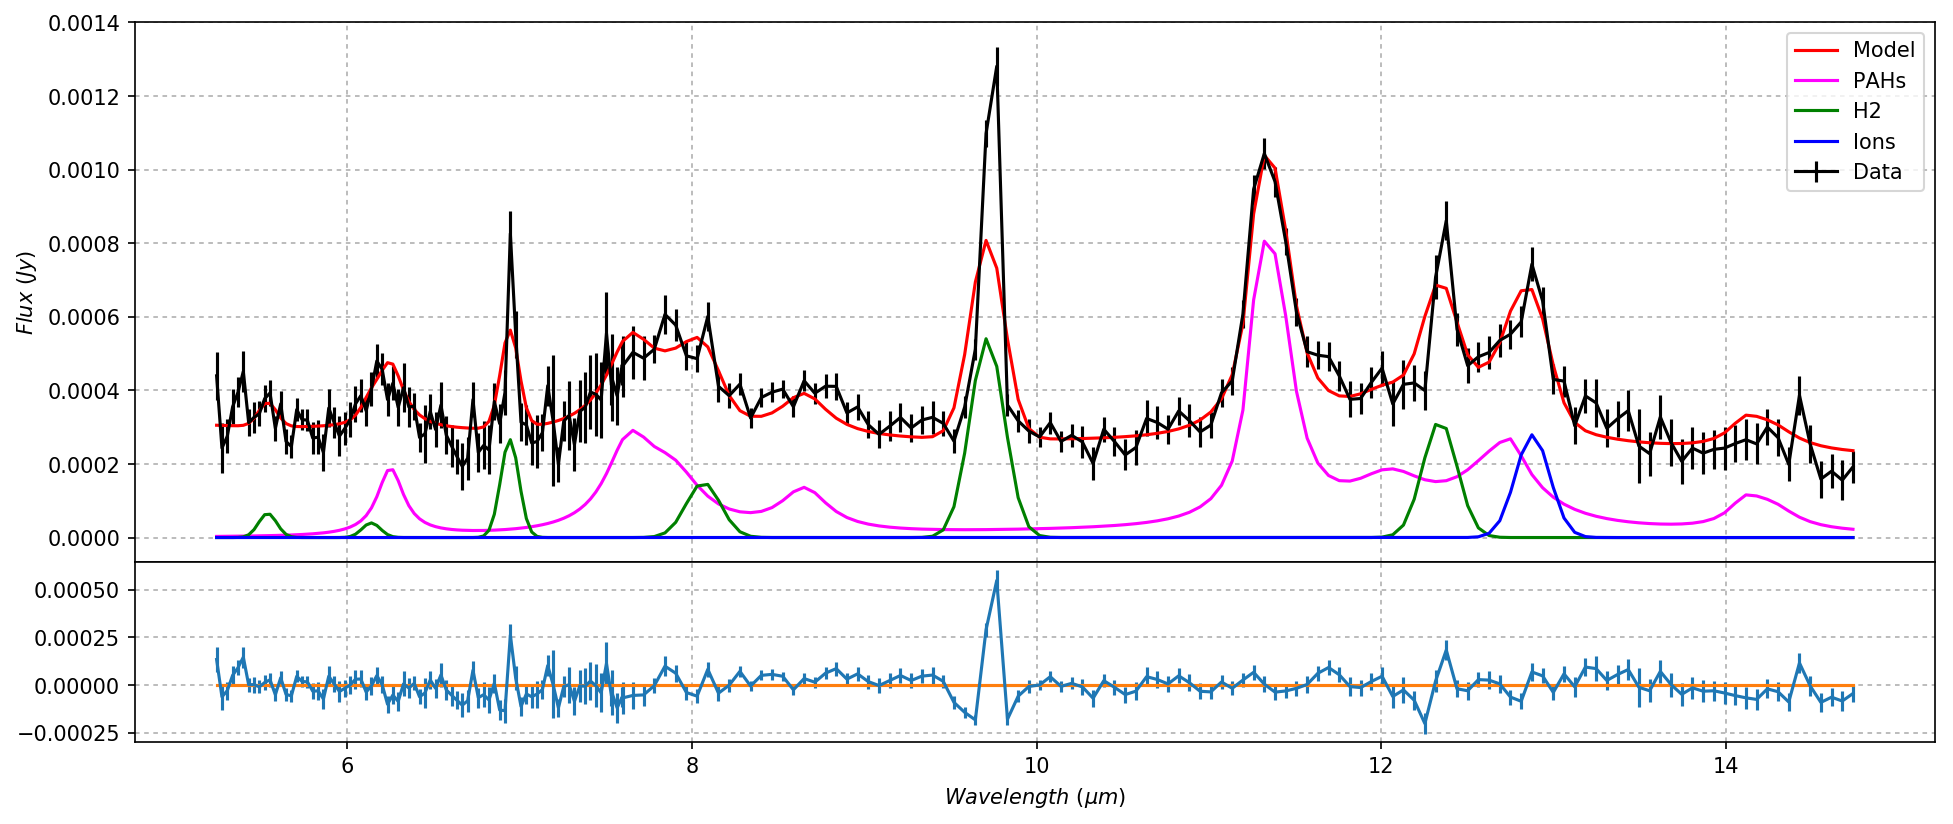

In [9]:
#Select spaxel
spec=data_cube[:,8,16]
specerr=error_cube[:,8,16]

#Composite model (powerlaw + PAHs + H2 + Atomic lines, no extinction)
generic_mod = p_law + silicate + pahs + gaussH2  + gaussAt

print(generic_mod.param_names)

#Fit and plot
spax_result=fit_and_plot(spec,specerr,generic_mod,generic_pars,False)

#Save results
save_modelresult(spax_result, 'OnePointResult.sav')

#Update generic model starting parameters
for par in spax_result.params:
    value=spax_result.params[par].value
    vary=spax_result.params[par].vary
    minus=spax_result.params[par].min
    if minus==float("-inf"):
        minus=None
    generic_pars[par].set(value,vary=vary,min=minus)
    

Plot of observed flux density (black), model fit (red), and residuals (bottom panel).  This spaxel has strong H2 emission at 9.6 microns and 8 micron PAH and [Ne II] 12.8 micron emission from star-forming regions.

## Fit the Entire Cube
Identify NaNs, then create list of models (based on generic model), one entry per NaN-free spaxel. Next launch the multiprocessing Pool, limited to number of available cores minus one. Fitting the entire cube (900 spaxels) takes about 2 minutes to fit with 7 processes running in parallel.

In [204]:
cube_res = mp.Manager().dict()

#The fit method is redefined as a top-level function to make it pickle-able for multiprocessing.Pool
def modfit(spaxel, generic_pars, weights, x):
        modf=generic_mod.fit(spaxel, generic_pars, weights=1./spaxerr, x=x)
        return modf.dumps()

#Helper to either assign a NaN result or fit a single non-NaN spaxel
def fit_point(args):
        a,b,spaxel,spaxerr,x,generic_pars,nancheck = args
        print(a, b, len(spaxel), mp.current_process().name)
        if nancheck == False:
            res_point=modfit(spaxel, generic_pars, weights=1./spaxerr, x=x)

            cube_res[(a,b)] = res_point 
        elif nancheck == True:
            cube_res[(a,b)] = float('nan')
        return 

#Extraction region dimensions (trimmed cube)
astart=0; aend=ysize
bstart=0; bend=zsize

#Check for NaNs, select data, and set model start parameters for each spaxel
pooldata=[]
for a in np.arange(astart,aend):
    for b in np.arange(bstart,bend):        
        nancheck = False
        for point in data_cube[:,a,b]:
            if np.isnan(point) == True or point == 0:
                nancheck = True
        
        #Copy spaxel data vectors
        spaxel = 1.0*np.array(data_cube[:,a,b])
        spaxerr= 1.0*np.array(error_cube[:,a,b])
        wavelen= 1.0*np.array(x)
        
        pooldata.append([a,b,spaxel,spaxerr,wavelen,generic_pars,nancheck])


#Launch Multiprocessing Pool
start_time = time.time()
if __name__ == '__main__':
    with Pool(mp.cpu_count() - 1) as pool:
        pool.map(fit_point,pooldata)    

print('Time count')
print("--- %s seconds ---" % (time.time() - start_time))

#Save model fit
with open('MPF_cube_result_model.sav', 'wb') as fp:
    pickle.dump(cube_res.items(), fp)

#Load model fit to full cube
cube_res = mp.Manager().dict()
with open ('MPF_cube_result_model.sav', 'rb') as fp:
        restore_cube = pickle.load(fp)
for line in restore_cube:
    pos=line[0]
    cube_res[pos] = line[1]

0 0 194 ForkPoolWorker-54
1 3 194 ForkPoolWorker-55
0 1 194 ForkPoolWorker-54
0 2 194 ForkPoolWorker-54
2 6 194 ForkPoolWorker-56
3 9 194 ForkPoolWorker-57
4 12 194 ForkPoolWorker-58
5 15 194 ForkPoolWorker-59
6 18 194 ForkPoolWorker-60
0 3 194 ForkPoolWorker-54
4 13 194 ForkPoolWorker-58
6 19 194 ForkPoolWorker-60
1 4 194 ForkPoolWorker-55
5 16 194 ForkPoolWorker-59
3 10 194 ForkPoolWorker-57
6 20 194 ForkPoolWorker-60
4 14 194 ForkPoolWorker-58
4 15 194 ForkPoolWorker-58
0 4 194 ForkPoolWorker-54
2 7 194 ForkPoolWorker-56
6 21 194 ForkPoolWorker-60
4 16 194 ForkPoolWorker-58
3 11 194 ForkPoolWorker-57
1 5 194 ForkPoolWorker-55
5 17 194 ForkPoolWorker-59
6 22 194 ForkPoolWorker-60
3 12 194 ForkPoolWorker-57
2 8 194 ForkPoolWorker-56
4 17 194 ForkPoolWorker-58
5 18 194 ForkPoolWorker-59
2 9 194 ForkPoolWorker-56
1 6 194 ForkPoolWorker-55
6 23 194 ForkPoolWorker-60
3 13 194 ForkPoolWorker-57
0 5 194 ForkPoolWorker-54
4 18 194 ForkPoolWorker-58
5 19 194 ForkPoolWorker-59
3 14 194 ForkPoo

### Total flux and Reduced Chi^2 Maps
Display total flux image (observed flux cube collapsed along wavelength direction) and reduced Chi^2 image for model fit in square sub-region.

/Users/pogle/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/colors.py:927: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


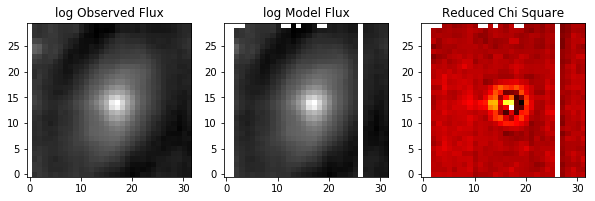

In [64]:
#Sum observed flux in each spaxel
cube_tflux=np.sum(data_cube,axis=0)[0:ysize,0:zsize]

#Sum model flux in each spaxel
tcube_chi=np.zeros((ysize, zsize))
tcube_modflux=np.zeros((ysize, zsize))
funcdefs = {}
#modres = lmfit.model.ModelResult(lmfit.Model(gaussian), lmfit.Parameters())
modres=spax_result
for pos, dumpval in cube_res.items():
    #for pos, dumpval in cube_res:
    if str(cube_res[pos])=='nan':
        tcube_modflux[pos]=np.float('nan')
        tcube_chi[pos]=np.float('nan')
    else:
        result = modres.loads(dumpval, funcdefs=funcdefs)
        tcube_modflux[pos]=np.sum(result.best_fit)
        tcube_chi[pos]=result.redchi

f,(ax1,ax2,ax3)=plt.subplots(1,3, figsize=(10,15))
ax1.set_title('log Observed Flux')
ax1.imshow(cube_tflux, origin='lower', cmap='gray', norm=LogNorm())
ax2.set_title('log Model Flux')
ax2.imshow(tcube_modflux, origin='lower', cmap='gray', norm=LogNorm())
ax3.set_title('Reduced Chi Square')
ax3.imshow(cube_tflux-tcube_modflux, origin='lower', cmap='hot')
#ax3.colorbar()
plt.show()

Collapsed cube maps, showing observed flux, model flux, and Chi^2/DF.  White regions with NaNs in the input data cube also have NaNs in the output model cube along the left and top edges and in column 26.  Residuals in the nucleus may either be the result of inadequate PSF sampling or mis-fit AGN model.

### Line maps
Create H2 9.6 micron, [Ne II] 12.8 micron, PAH 7.6, and PAH 11.3 micron line maps for 3-color image.

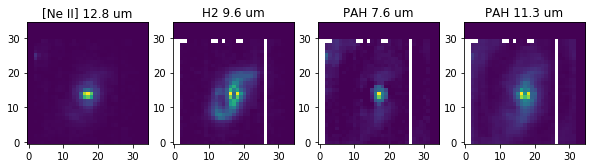

In [65]:
h2cube_flux=np.zeros((35, 35))
necube_flux=np.zeros((35, 35))
pahcube_ion_flux=np.zeros((35, 35))
pahcube_neutral_flux=np.zeros((35, 35))

line='96'
i=0
for pos, dumpval in cube_res.items():
    if str(cube_res[pos])=='nan':
        h2cube_flux[pos]=float('nan')
    else:
        lflux=0.
        result = modres.loads(dumpval, funcdefs=funcdefs)
        prefix = 'h'+line+'_'
        amp, cen, std = gaussian_extractpars(prefix,result)               
        lflux= gaussianline_flux(amp,std,cen)                      
        h2cube_flux[pos]=lflux

line='NeII'
for pos, dumpval in cube_res.items():
    if str(cube_res[pos])=='nan':
        necube_flux[pos]=0.0
    else:
        result = modres.loads(dumpval, funcdefs=funcdefs)
        prefix = line+'_'
        amp, cen, std = gaussian_extractpars(prefix,result)               
        lflux= gaussianline_flux(amp,std,cen)                      
        necube_flux[pos]=lflux

line='pahdust1'
for pos, dumpval in cube_res.items():
    if str(cube_res[pos])=='nan':
        pahcube_ion_flux[pos]=float('nan')
        pahcube_neutral_flux[pos]=float('nan')
    else:
        result = modres.loads(dumpval, funcdefs=funcdefs)
        prefix = line+'_'
        ampl_76, ampl_113 = pahdust_extractpars(prefix,result)  
        pah_76_flux = drudeline_flux(ampl_76,0.044,7.60)
        pah_113_flux = drudeline_flux(ampl_113,0.032,11.33)                      
        pahcube_ion_flux[pos]=pah_76_flux
        pahcube_neutral_flux[pos]=pah_113_flux
        
f,(ax1,ax2,ax3,ax4)=plt.subplots(1,4, figsize=(10,15))

ax1.set_title('[Ne II] 12.8 um')
ax1.imshow(necube_flux, origin='lower')
ax2.set_title('H2 9.6 um')
ax2.imshow(h2cube_flux, origin='lower')
ax3.set_title('PAH 7.6 um')
ax3.imshow(pahcube_ion_flux, origin='lower')
ax4.set_title('PAH 11.3 um')
ax4.imshow(pahcube_neutral_flux, origin='lower')
           
plt.show()

### RGB line and PAH feature flux maps.

/Users/pogle/miniconda3/envs/astroconda/lib/python3.5/site-packages/astropy/visualization/lupton_rgb.py:158: RuntimeWarning: invalid value encountered in less
  c[c < 0] = 0                # individual bands can still be < 0, even if fac isn't


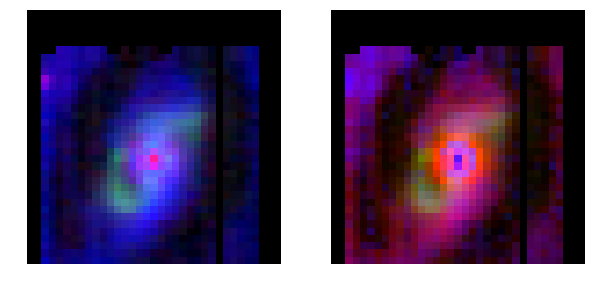

In [66]:
#Make RGB images
m58_neii_pah0_h2 = make_lupton_rgb(2.5*necube_flux, h2cube_flux, pahcube_neutral_flux, minimum=0, Q=5, stretch=0.000000000000004, filename="m58_NeII_H96_PAH113.png")
m58_pah_h2 = make_lupton_rgb(pahcube_neutral_flux, h2cube_flux, 1.2*pahcube_ion_flux, minimum=0, Q=5, stretch=0.000000000000005, filename="m58_PAH113_H96_PAH76.png")

#Two-panel figure
f,(ax1,ax2)=plt.subplots(1,2, figsize=(10,15))
ax1.axis('off')
ax1.imshow(m58_neii_pah0_h2,origin='lower')
ax2.axis('off')
ax2.imshow(m58_pah_h2,origin='lower')
plt.show()

3-color RGB images. Left: r = [Ne II] 12.8 micron, g = H2 S(3) 9.6 micron, b = PAH 11.3 micron. Ionized atomic gas in the active galactic nucleus shows up as red, shocked regions are green, and dust emission is blue. Right: r = PAH 11.3 micron, g = H2 S(3) 9.6 micron, b = PAH 7.6 micron. Neutral PAH emission shows up as red, ionized PAH emission from PDRs in star-forming regions is blue, and shocked regions are green. 

## Extract and model cube sub-regions 
### Make spectral region masks 
Define spectral extraction regions based on spatial location, line flux, and line or feature ratios.

/Users/pogle/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in greater_equal
/Users/pogle/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in true_divide
/Users/pogle/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in greater
/Users/pogle/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in greater_equal
/Users/pogle/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in less
/Users/pogle/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in greater_equal
/Users/pogle/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel/__main__.py:16: RuntimeW

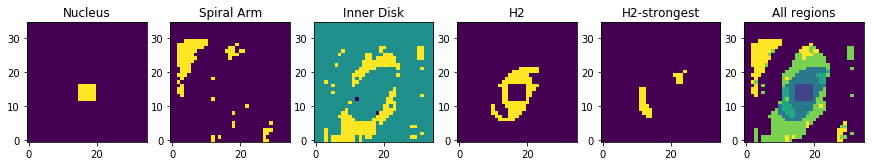

In [67]:
#Nucleus extraction region, defined by 5x5 square
nuc_mask=np.zeros((35, 35))
for a in arange(-2,3):
    for b in arange(-2,3):
        nuc_mask[14-a,17-b]=int(1)

#Spiral arm extraction region
arm_mask=np.where(((pahcube_neutral_flux>=0.155e-14) &((pahcube_ion_flux/pahcube_neutral_flux)>0.8) & (nuc_mask==0)),1,0)

#Inner disk extraction region        
pah_mask=np.where(((pahcube_neutral_flux>=0.155e-14) & (h2cube_flux<1e-15) & (nuc_mask==0)),1,0) - arm_mask
pah_mask[:,0:3]=int(0)  #Trim edges of cube
pah_mask[28:,:]=int(0)

#Regions of strongest H2 emission
h2s_mask=np.where(((h2cube_flux>=1e-15)&((h2cube_flux/pahcube_neutral_flux)>0.7) & (nuc_mask==0)),1,0)

#H2 extraction region
h2_mask=np.where(((h2cube_flux>=1e-15) & (nuc_mask==0)),1,0)-h2s_mask

#M58 combined central regions mask (excluding spiral arm)
m58_mask=nuc_mask + h2_mask*2 + h2s_mask*3 + pah_mask*4 +arm_mask*5

f,((ax1,ax2,ax3,ax4,ax5,ax6))=plt.subplots(1,6,figsize=(15,10))

ax1.set_title('Nucleus')
ax1.imshow(nuc_mask,origin='lower')
ax2.set_title('Spiral Arm')
ax2.imshow(arm_mask,origin='lower')
ax3.set_title('Inner Disk')
ax3.imshow(pah_mask,origin='lower')
ax4.set_title('H2')
ax4.imshow(h2_mask,origin='lower')
ax5.set_title('H2-strongest')
ax5.imshow(h2s_mask,origin='lower')
ax6.set_title('All regions')
ax6.imshow(m58_mask,origin='lower')

plt.show()

Extraction region masks based on spatial and emission line or PAH feature strengths.

### Extract spectra from mask regions

Spectra summed over five different regions: Spiral Arm, Nucleus, PAH, H2, and Strongest H2

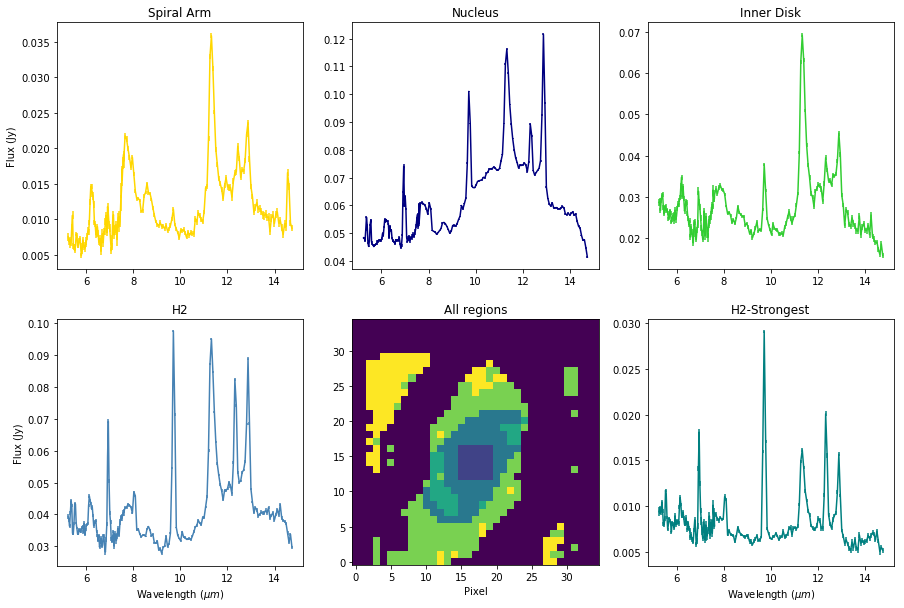

In [68]:
nuc_spec=np.zeros(xsize,)
nuc_err=np.zeros(xsize,)
pah_spec=np.zeros(xsize,)
pah_err=np.zeros(xsize,)
h2_spec=np.zeros(xsize,)
h2_err=np.zeros(xsize,)
arm_spec=np.zeros(xsize,)
arm_err=np.zeros(xsize,)
h2s_spec=np.zeros(xsize,)
h2s_err=np.zeros(xsize,)
for a in arange(0,ysize):
    for b in arange(0,zsize):
        if nuc_mask[a,b]==1:
            spec_pix,err_pix=extract_spec(a,b)
            nuc_spec=nuc_spec+spec_pix
            nuc_err=nuc_err+err_pix**2
        if pah_mask[a,b]==1:
            spec_pix,err_pix=extract_spec(a,b)
            pah_spec=pah_spec+spec_pix
            pah_err=pah_err+err_pix**2
        if h2_mask[a,b]==1:
            spec_pix,err_pix=extract_spec(a,b)
            h2_spec=h2_spec+spec_pix
            h2_err=h2_err+err_pix**2
        if arm_mask[a,b]==1:
            spec_pix,err_pix=extract_spec(a,b)
            arm_spec=arm_spec+spec_pix
            arm_err=arm_err+err_pix**2
        if h2s_mask[a,b]==1:
            spec_pix,err_pix=extract_spec(a,b)
            h2s_spec=h2s_spec+spec_pix
            h2s_err=h2s_err+err_pix**2

nuc_err=sqrt(nuc_err)
pah_err=sqrt(pah_err)
h2_err=sqrt(h2_err)
arm_err=sqrt(arm_err)
h2s_err=sqrt(h2s_err)
f,((ax1,ax2,ax3),(ax4,ax5,ax6))=plt.subplots(2,3,figsize=(15,10))

ax1.set_title('Spiral Arm')
ax1.errorbar(x,arm_spec,yerr=arm_err, c='gold')
ax1.set_ylabel('Flux (Jy)')

ax2.set_title('Nucleus')
ax2.errorbar(x,nuc_spec,yerr=nuc_err, c='navy')

ax3.set_title('Inner Disk')
ax3.errorbar(x,pah_spec,yerr=pah_err, c='limegreen')

ax4.set_title('H2')
ax4.errorbar(x,h2_spec,yerr=h2_err, c='steelblue')
ax4.set_xlabel(r"Wavelength $(\mu m)$")
ax4.set_ylabel('Flux (Jy)')

ax5.set_title('All regions')
ax5.imshow(m58_mask,origin='lower')
ax5.set_xlabel('Pixel')

ax6.set_title('H2-Strongest')
ax6.errorbar(x,h2s_spec,yerr=h2s_err,c='teal')
ax6.set_xlabel(r"Wavelength $(\mu m)$")
plt.show()



### Save spectra to files

In [69]:
#Save spec regions

np.savetxt(targname+'_spec_nuc.dat', np.column_stack((x, nuc_spec, nuc_err)),header='Wavelength[microns]     Flux_Nucleus[Jy]      Err_Flux_Nucleus')
np.savetxt(targname+'_spec_h2.dat', np.column_stack((x, h2_spec, h2_err)), header='Wavelength[microns]     Flux_H2[Jy]      Err_H2')
np.savetxt(targname+'_spec_h2s.dat', np.column_stack((x, h2_spec, h2_err)), header='Wavelength[microns]     Flux_H2s[Jy]      Err_H2s')
np.savetxt(targname+'_spec_pah.dat', np.column_stack((x, pah_spec, pah_err)), header='Wavelength[microns]     Flux_PAH[Jy]      Err_PAH')
np.savetxt(targname+'_spec_arm.dat', np.column_stack((x, arm_spec, arm_err)), header='Wavelength[microns]     Flux_Arm[Jy]      Err_Arm')



### Fit spectra of regions

#### Generic model components
Model 14 individual PAH components with all amplitudes free. It would be computationally expensive to do this
for the full cube, but only takes a couple of seconds for the summed region spectra.

In [122]:
#Power Law
p_law = Model(powerlaw,prefix='pwl_')
generic_pars = p_law.make_params()      #Generate the parameters
setpar(generic_pars,'pwl_c1',0.005,True,None)
setpar(generic_pars,'pwl_c2',0.0015,True,None)

#Individual PAHs
drudes=Model(Modelcero)
allpahlines=['52','62','74','76','78','83','86','112','113','119','126','134','140','141'] 
for line in allpahlines:
    prefix='PAH'+line+'_'  
    drudes+=Model(drude,prefix=prefix)  
generic_pars.update(drudes.make_params())

drude_defpar('PAH52', 5.27, 0.034, 0.05,generic_pars)
drude_defpar('PAH62', 6.22, 0.030, 0.05,generic_pars)
drude_defpar('PAH74', 7.42, 0.126, 0.05,generic_pars)
drude_defpar('PAH76', 7.60, 0.044, 0.05,generic_pars)
drude_defpar('PAH78', 7.85, 0.053, 0.5,generic_pars)
drude_defpar('PAH83', 8.33, 0.05, 0.5,generic_pars)
drude_defpar('PAH86', 8.61, 0.039, 0.5,generic_pars)
drude_defpar('PAH112', 11.23, 0.012, 0.5,generic_pars)
drude_defpar('PAH113', 11.33, 0.032, 0.5,generic_pars)
drude_defpar('PAH119', 11.99, 0.045, 0.5,generic_pars)
drude_defpar('PAH126', 12.62, 0.042, 0.5,generic_pars)
drude_defpar('PAH134', 13.48, 0.04, 0.5,generic_pars)
drude_defpar('PAH140', 14.04, 0.016, 0.5,generic_pars)
drude_defpar('PAH141', 14.19, 0.025, 0.5,generic_pars)

#Silicate dust emission
prefix='sidust1_'
silicate= Model(sidust,prefix=prefix)
generic_pars.update(silicate.make_params())
sidust_defpar('sidust1', 190.,1.E-4,generic_pars)

#Gaussians with FWHM and X central from Smith et al 2007
#H2 molecular
h2lines=['55','61','69','80','96','122']
gaussH2=Model(Modelcero)
for line in h2lines:
    prefix='h'+line+'_'
    gaussH2+=Model(gaussian,prefix=prefix)
generic_pars.update(gaussH2.make_params())
gaussian_defpar('h55',0.05, 5.511, 0.053,generic_pars)
gaussian_defpar('h61',0.05, 6.109, 0.053,generic_pars)
gaussian_defpar('h69',0.05, 6.909, 0.053,generic_pars)
gaussian_defpar('h80',0.05, 8.026, 0.100,generic_pars)
gaussian_defpar('h96',0.05, 9.665, 0.100,generic_pars)
gaussian_defpar('h122',0.05, 12.278, 0.100,generic_pars)

#Atomic lines
atomiclines=['ArII','SIV','NeII']
gaussAt=Model(Modelcero)
for line in atomiclines:
    prefix = line+'_'
    gaussAt+=Model(gaussian,prefix=prefix)
generic_pars.update(gaussAt.make_params())
gaussian_defpar('ArII',0.05, 6.985, 0.053,generic_pars)
gaussian_defpar('SIV',0.05, 10.511, 0.100,generic_pars)
gaussian_defpar('NeII',0.05, 12.813, 0.100,generic_pars)


#### Spiral arm spectral fit

In [181]:
#Spiral arm spectrum
spec=arm_spec
specerr=arm_err

#Model (powerlaw + individual PAHs + H2 and Atomic lines, no extinction)
model = p_law + drudes + gaussAt + gaussH2

#Adjust power law starting parameters 
setpar(generic_pars,'pwl_c1',0.01,True,None)
setpar(generic_pars,'pwl_c2',0.001,True,None)

#Model Results
arm_result = model.fit(spec, generic_pars, weights=1./specerr, x=x)
arm_model = arm_result.best_fit 
arm_residual = spec - arm_model
arm_modelcomps=model_comps(arm_result)

#Plot
#arm_result=fit_and_plot(spec,specerr,model,generic_pars,False)

odict_keys(['pwl_', 'Modelcero', 'PAH52_', 'PAH62_', 'PAH74_', 'PAH76_', 'PAH78_', 'PAH83_', 'PAH86_', 'PAH112_', 'PAH113_', 'PAH119_', 'PAH126_', 'PAH134_', 'PAH140_', 'PAH141_', 'ArII_', 'SIV_', 'NeII_', 'h55_', 'h61_', 'h69_', 'h80_', 'h96_', 'h122_'])


Model fit to integrated spectrum of spiral arm region. 

#### H2-strongest region spectral fit

In [189]:
#H2 region spectrum
spec=h2s_spec
specerr=h2s_err

#Model (powerlaw + individual PAHs + H2 and Atomic lines, no extinction)
model = p_law + drudes + gaussAt + gaussH2

#Adjust power law starting parameters 
setpar(generic_pars,'pwl_c1',0.002,True,None)
setpar(generic_pars,'pwl_c2',0.0015,True,None)

#Model Results
h2s_result = model.fit(spec, generic_pars, weights=1./specerr, x=x)
h2s_model = h2s_result.best_fit 
h2s_residual = spec - h2s_model
h2s_modelcomps=model_comps(h2s_result)

#Plot
#h2s_result=fit_and_plot(spec,specerr,model,generic_pars,False)

odict_keys(['pwl_', 'Modelcero', 'PAH52_', 'PAH62_', 'PAH74_', 'PAH76_', 'PAH78_', 'PAH83_', 'PAH86_', 'PAH112_', 'PAH113_', 'PAH119_', 'PAH126_', 'PAH134_', 'PAH140_', 'PAH141_', 'ArII_', 'SIV_', 'NeII_', 'h55_', 'h61_', 'h69_', 'h80_', 'h96_', 'h122_'])


Model fit to integrated spectrum of H2-strongest region. 

#### Nucleus spectral fit

odict_keys(['pwl_', 'sidust1_', 'Modelcero', 'PAH52_', 'PAH62_', 'PAH74_', 'PAH76_', 'PAH78_', 'PAH83_', 'PAH86_', 'PAH112_', 'PAH113_', 'PAH119_', 'PAH126_', 'PAH134_', 'PAH140_', 'PAH141_', 'h55_', 'h61_', 'h69_', 'h80_', 'h96_', 'h122_', 'ArII_', 'SIV_', 'NeII_'])
Time count
--- 0.7671940326690674 seconds ---
Chi square red= 37.38784370231527


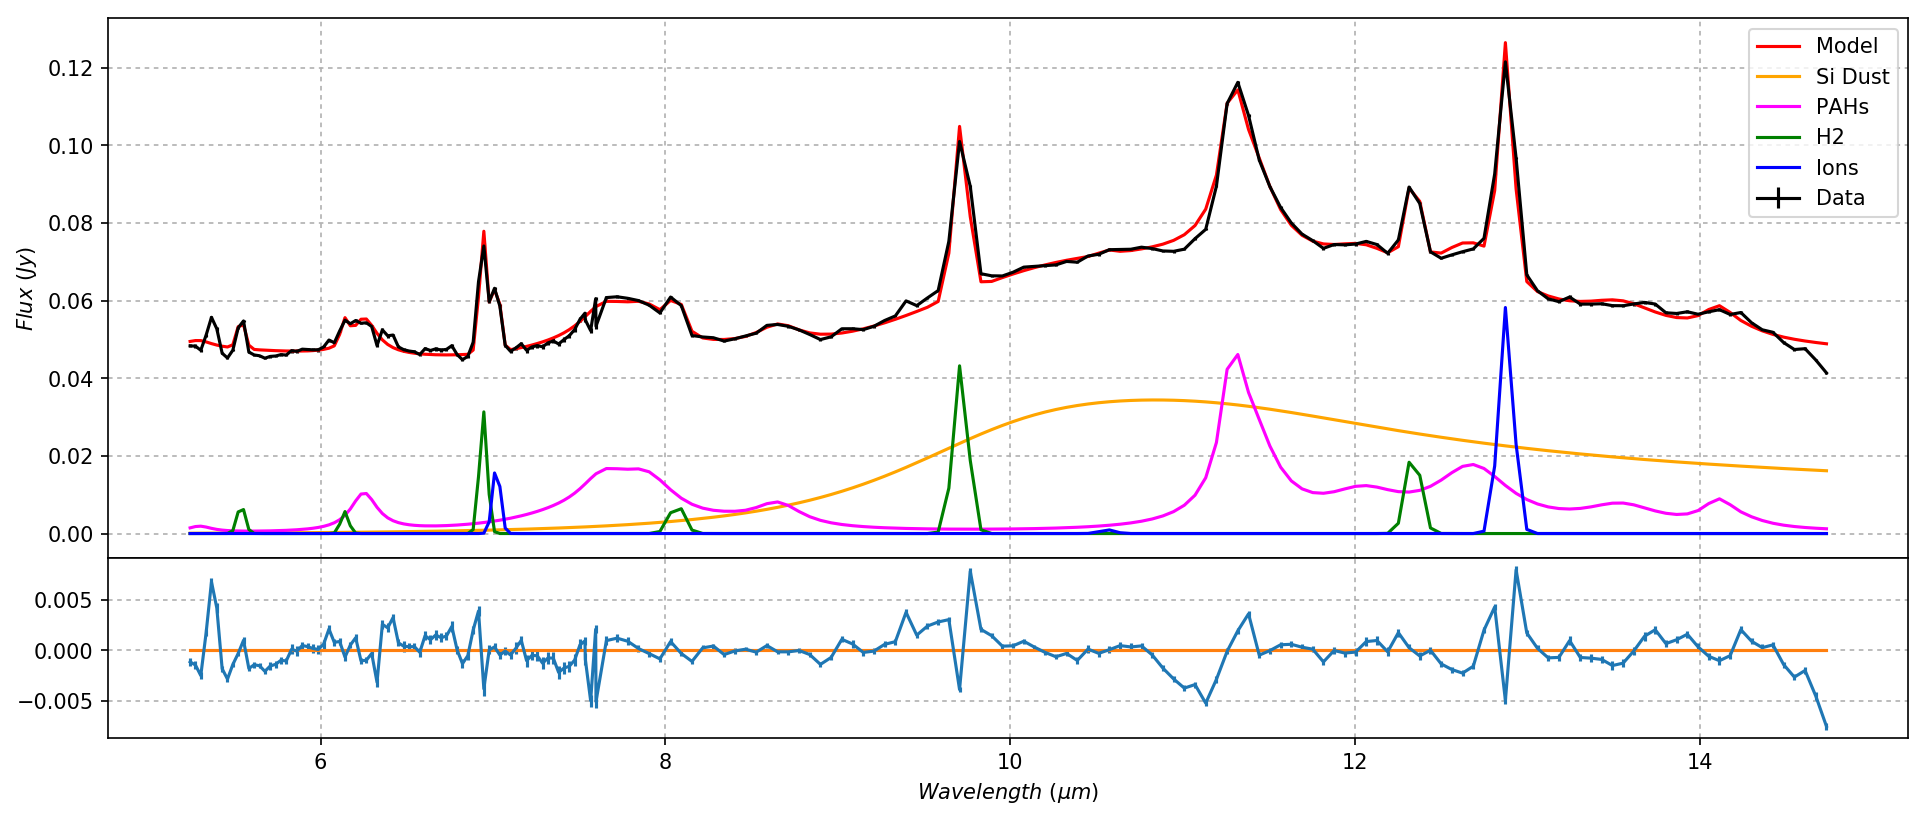

In [183]:
#Nucleus spectrum
spec=nuc_spec
specerr=nuc_err

#Model (powerlaw + AGN silicate emission + individual PAHs + H2 and Atomic lines, no extinction)
model = p_law + silicate + drudes + gaussH2 + gaussAt

#Adjust power law and silicate dust starting parameters
setpar(generic_pars,'pwl_c1',0.005,True,None)
setpar(generic_pars,'pwl_c2',0.01,True,None)
sidust_defpar('sidust1', 190.,2.E-4,generic_pars)

#Model Results
nuc_result = model.fit(spec, generic_pars, weights=1./specerr, x=x)
nuc_model = nuc_result.best_fit 
nuc_residual = spec - nuc_model
nuc_modelcomps=model_comps(nuc_result)

#Plot
nuc_result=fit_and_plot(spec,specerr,model,generic_pars,True)

Model fit to nucleus, including fixed-temperature AGN silicate emission. 

In [184]:
nuc_result
#result.fit_report(show_correl=False)

Fit parameters for spectrum of nucleus

## Summary Plot

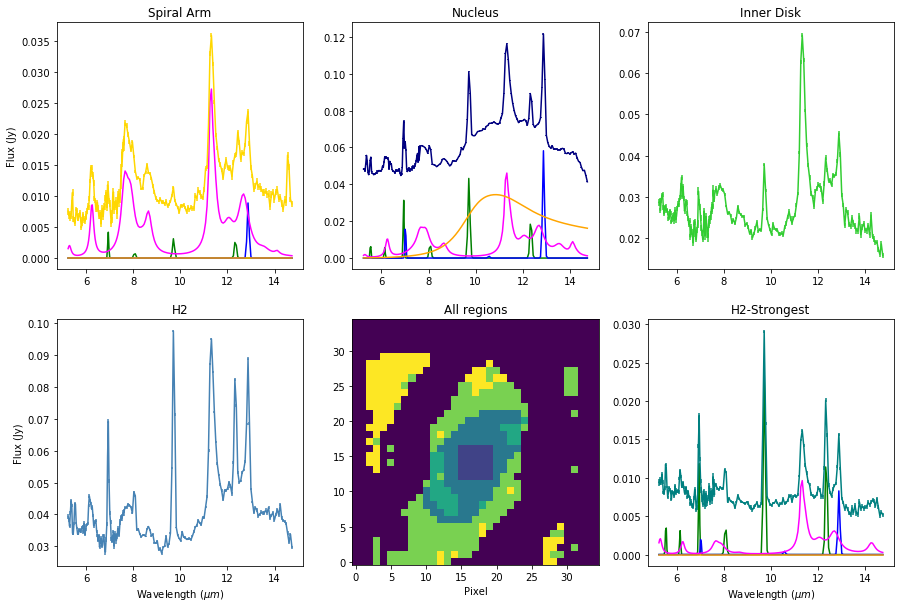

In [190]:

    
f,((ax1,ax2,ax3),(ax4,ax5,ax6))=plt.subplots(2,3,figsize=(15,10))

ax1.set_title('Spiral Arm')
ax1.set_ylabel('Flux (Jy)')
ax1.errorbar(x,arm_spec,yerr=arm_err, c='gold')
ax1.plot(x,arm_modelcomps[1],label='H2',c='g')
ax1.plot(x,arm_modelcomps[2],label='Ions',c='b')
ax1.plot(x,arm_modelcomps[3],label='PAHs',c='magenta')
ax1.plot(x,arm_modelcomps[4],label='Si Dust', c='orange')

ax2.set_title('Nucleus')
ax2.errorbar(x,nuc_spec,yerr=nuc_err, c='navy')
#ax2.plot(x, fit_model,label='Model',c='red')
ax2.plot(x,nuc_modelcomps[1],label='H2',c='g')
ax2.plot(x,nuc_modelcomps[2],label='Ions',c='b')
ax2.plot(x,nuc_modelcomps[3],label='PAHs',c='magenta')
ax2.plot(x,nuc_modelcomps[4],label='Si Dust', c='orange')

ax3.set_title('Inner Disk')
ax3.errorbar(x,pah_spec,yerr=pah_err, c='limegreen')

ax4.set_title('H2')
ax4.set_xlabel(r"Wavelength $(\mu m)$")
ax4.set_ylabel('Flux (Jy)')
ax4.errorbar(x,h2_spec,yerr=h2_err, c='steelblue')

ax5.set_title('All regions')
ax5.set_xlabel('Pixel')
ax5.imshow(m58_mask,origin='lower')

ax6.set_title('H2-Strongest')
ax6.set_xlabel(r"Wavelength $(\mu m)$")
ax6.errorbar(x,h2s_spec,yerr=h2s_err,c='teal')
ax6.plot(x,h2s_modelcomps[1],label='H2',c='g')
ax6.plot(x,h2s_modelcomps[2],label='Ions',c='b')
ax6.plot(x,h2s_modelcomps[3],label='PAHs',c='magenta')
ax6.plot(x,h2s_modelcomps[4],label='Si Dust', c='orange')

plt.show()

<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/>

Notebook created by Patrick Ogle and Ivan Lopez.